## Imports
Importing all required modules

In [16]:
import random # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
sns.set_style("white")

## Defining a Graph
Graph class for creating graphs to use with algorithms. All graphs are complete and weighted.

Supports 4 types of graphs:
- `asymmetric`: Directed graph with random weights
- `symmetric`: Undirected graph with random weights
- `easy`: All edges have the weight 2, except for a cycle which has edges with the weight 1
- `Euclidean`: Vertices placed on a 2D coordinate plane and the weight of the edges is the Euclidean distance between them

Examples:
- Creating a Euclidean graph with 10 vertices: `G = Graph(10, 'Euclidean')`
- Getting the number of vertices: `G.n`
- Getting the weight of the edge from $a$ to $b$: `G[a][b]`

In [4]:
class Graph:
    """ Random graphs """
    def __init__(self, n=0, type="asymmetric", MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if type == "symmetric": self.__random_symmetric_graph(n, MAX_WEIGHT)
        elif type == "Euclidean": self.__random_euclidean_graph(n, MAX_X,MAX_Y)
        elif type == "easy": self.__random_cycle_graph(n)
        else: self.__random_asymmetric_graph(n, MAX_WEIGHT) # assume "asymmetric" otherwise
            
    def __getitem__(self, i):
        """ Allow indexing to get the weights """
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self, n, MAX_WEIGHT):
        """ Asymmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(n):
                if i == j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1, MAX_WEIGHT)

    def __random_symmetric_graph(self, n, MAX_WEIGHT):
        """ Symmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(i + 1, n):
                w = randint(1, MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        """ Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) """
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1, n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a, b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self, n, MAX_X, MAX_Y):
        """ Symmetric adjacency matrix of a Euclidean graph of size nxn """
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points) < n: # We may get duplicate (x,y) so we try until we get enough points
            x, y = randint(0, MAX_X), randint(0, MAX_Y)
            points.add((x, y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1, n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points = points

### Utility functions on the Graph

- **cost(Graph, cycle)**: Calculates the cost of a cycle in the graph (The first and last elements need to be the same in the cycle).
- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?)**: Draws the graph. If a path is specified, only draws the edges in the path. The weight of the edges is not shown for graphs that have more than 15 vertices.

In [5]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

In [6]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If path is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
        # Add last edge
        a = path[-1]
        b = path[0]
        nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None, weight_tags=False):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if weight_tags:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

Example

5x5 Euclidean graph:
Points: [(175, 123), (7, 13), (162, 67), (135, 189), (139, 11)]


,0,1,2,3,4
0,inf,200.808366,57.489129,77.175126,117.643529
1,200.808366,inf,164.137138,217.623528,132.015151
2,57.489129,164.137138,inf,124.951991,60.539243
3,77.175126,217.623528,124.951991,inf,178.044938
4,117.643529,132.015151,60.539243,178.044938,inf


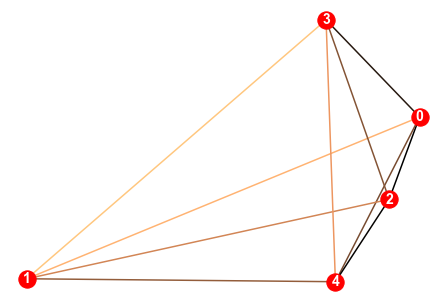

In [111]:
G = Graph(5,"Euclidean")
show(G)
draw(G)

# Simulated Annealing

The simulated annealing algorithm is an optimization method which mimics the slow cooling of metals. In simulated annealing, the equivalent of temperature is a measure of the randomness by which changes are made to the path, seeking to minimise it. When the temperature is high, larger random changes are made, avoiding the risk of becoming trapped in a local minimum (of which there are usually many in a typical travelling salesman problem), then homing in on a near-optimal minimum as the temperature falls.
Overview of the Algorithm's implementation
1. Initial path is formed
1. Algorithm swaps path between two cities at random
1. If cost of overall path is lowered, new path is kept
1. If not then the path still has a chance to be kept which is heavily influenced by the temperature
1. The higher the temp, the more chance the path is still swapped.


# Implementation

In [ ]:
#Placeholder used for initial path, will likely change this to randomized path instead
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    return (visited, cost(G, visited+[0]))

In [103]:
def SA(G):
    initial_temp = 100
    final_temp = 0
    current_temp = initial_temp
    #uses Greedy for initial path as well as for comparision, may need to be changed
    best_path, best_cost = greedy_nearest_neighbour(G)
    print('inital greedy path was ', best_path, best_cost)
    current_path = best_path
    current_cost = best_cost
    while current_temp > final_temp: #swaps will continue to be performed until temp <= 0
        #chance of worse solution being accepted
        percentage = (current_temp / 400) * 100
        print('acceptanceChance = ', percentage, '%')
        probability = randint(0, initial_temp+300)
        city = (random.choice(G.vertices)) #randomly selects initial city
        next_city = random.choice(G.vertices)
        while city == next_city: #city cannot have path to itself
            next_city = random.choice(G.vertices)
        city_pos = current_path.index(city)
        current_path.remove(next_city)
        current_path.insert(city_pos+1, next_city)
        current_cost = cost(G, current_path)
        #always accept swap if cost is less than current, =<25% chance to accept worse solution
        if current_cost < best_cost or probability <= current_temp:
            best_path = current_path
            best_cost = current_cost
        current_temp -= 0.5 #lowers temp every loop
        print(current_path, current_cost, current_temp,'°C')
    return (best_path, best_cost) 
        
        
    

5x5 Euclidean graph:
Points: [(93, 98), (198, 39), (187, 116), (59, 9), (57, 42)]


,0,1,2,3,4
0,inf,120.440857,95.707889,95.273291,66.573268
1,120.440857,inf,77.781746,142.200563,141.031911
2,95.707889,77.781746,inf,166.832251,149.586096
3,95.273291,142.200563,166.832251,inf,33.060551
4,66.573268,141.031911,149.586096,33.060551,inf


inital greedy path was  [0, 4, 3, 1, 2] 415.32401584736095
acceptanceChance =  25.0 %
[0, 4, 3, 2, 1] 344.247815427267 99.5 °C
acceptanceChance =  24.875 %
[0, 4, 3, 2, 1] 344.247815427267 99.0 °C
acceptanceChance =  24.75 %
[0, 1, 4, 3, 2] 461.36556972603034 98.5 °C
acceptanceChance =  24.625 %
[0, 1, 2, 4, 3] 380.8692489058132 98.0 °C
acceptanceChance =  24.5 %
[0, 1, 2, 3, 4] 398.1154043740327 97.5 °C
acceptanceChance =  24.375 %
[0, 1, 2, 4, 3] 380.8692489058132 97.0 °C
acceptanceChance =  24.25 %
[1, 2, 4, 0, 3] 389.2144005650256 96.5 °C
acceptanceChance =  24.125 %
[1, 2, 4, 3, 0] 355.7016831662857 96.0 °C
acceptanceChance =  24.0 %
[1, 2, 3, 0, 4] 406.46055603324515 95.5 °C
acceptanceChance =  23.875 %
[1, 2, 3, 0, 4] 406.46055603324515 95.0 °C
acceptanceChance =  23.75 %
[1, 0, 2, 3, 4] 416.0415473555557 94.5 °C
acceptanceChance =  23.625 %
[1, 0, 2, 3, 4] 416.0415473555557 94.0 °C
acceptanceChance =  23.5 %
[1, 0, 3, 4, 2] 398.36079409090416 93.5 °C
acceptanceChance =  23.375 

([4, 3, 0, 1, 2], 273.1234532605694)

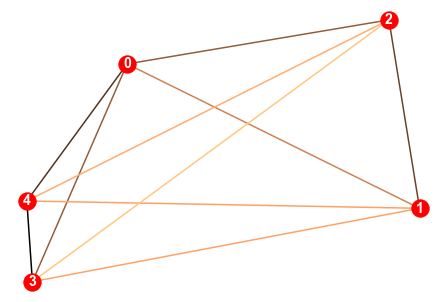

In [110]:
G = Graph(5, "Euclidean")
draw(G)
show(G)
SA(G)